#Golden Boot Winner Predictor

**Goal**  
Predict final top scorer using Understat data.

**Core Logic**  
- Actual goals so far (`goals`) are 100% fixed (banked reality).  
- Future goals estimated from xG rate adjusted for finishing skill (blend_factor = 0.4).  
- Realistic minutes projection: games_remaining × avg_min_per_game_so_far.

**Projection**  
expected_total = actual goals + adjusted remaining xG

**Simulation**  
100,000 Poisson Monte Carlo runs → prob_top_scorer_%  
(goals are rare count events → Poisson is mathematically ideal)

**Best View**  
Sort by expected_total → rewards players with high banked goals

**Output Focus**  
Emphasizes what has already happened while fairly modeling remaining variance.

## Key Variables Explained

| Variable                  | Meaning                                                                 | Role / Why Important                              |
|---------------------------|-------------------------------------------------------------------------|---------------------------------------------------|
| goals                     | Actual goals scored this season (real data)                             | Fixed base – 100% weight, banked reality          |
| xG                        | Cumulative expected goals (Understat)                                   | Measures chance quality so far                    |
| xG_per_90                 | xG per 90 minutes                                                       | Pure underlying rate                              |
| finishing_diff_per_90     | (goals - xG) per 90 minutes                                             | Over/underperformance (finishing skill/luck)      |
| adjusted_xG_per_90        | Blended future rate (blend 40% finishing diff)                          | Adjusted rate for remaining projection            |
| remaining_xG_adjusted     | Expected future goals using adjusted rate                               | Only estimated part                               |
| expected_total            | goals + remaining_xG_adjusted                                           | Best guess for final tally         |
| prob_top_scorer_%         | % of 100k sims where player finishes #1 (ties split)                    | Realistic probability accounting for variance     |

In [ ]:
!pip install soccerdata pandas numpy matplotlib seaborn

In [ ]:
!pip install --upgrade soccerdata

In [ ]:
import soccerdata as sd
import pandas as pd
import numpy as np

[02/24/26 14:15:30] INFO     No custom team name replacements found. You can configure these in       ]8;id=509087;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=350449;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_config.py#92\92]8;;\
                             /root/soccerdata/config/teamname_replacements.json.                                   

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=384483;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=272526;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_config.py#198\198]8;;\
                             /root/soccerdata/config/league_dict.json.                                             

In [ ]:
!pip show Python3

In [ ]:
!pip show soccerdata

Name: soccerdata
Version: 1.8.8
Summary: A collection of scrapers for soccer data from various websites / APIs.
Home-page: https://github.com/probberechts/soccerdata
Author: 
Author-email: Pieter Robberechts <pieter.robberechts@kuleuven.be>
License-Expression: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: html5lib, lxml, pandas, rich, seleniumbase, tqdm, unidecode, urllib3, wrapper-tls-requests
Required-by: 


#Initialize and fetch data

In [ ]:
#Initialize Understat for current season
understat = sd.Understat(leagues='ENG-Premier League', seasons='2025') # to acsess other leagues stats
# 'ESP-La Liga',
#  'FRA-Ligue 1',
#  'GER-Bundesliga',
#  'ITA-Serie A']

# Fetch player season stats
player_stats = understat.read_player_season_stats()
player_stats = player_stats.reset_index()

print("Player stats loaded. Shape:", player_stats.shape)
print("Columns:", player_stats.columns)

# Fetch schedule
schedule = understat.read_schedule()
schedule = schedule.reset_index()

[02/24/26 14:15:43] INFO     Saving cached data to /root/soccerdata/data/Understat                   ]8;id=636702;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=215123;file:///usr/local/lib/python3.12/dist-packages/soccerdata/_common.py#249\249]8;;\

[2026-02-24 14:15:43] INFO     TLSLibrary:load:435 - Downloading required library version v1.13.1...


                    INFO     Downloading required library version v1.13.1...                       ]8;id=548093;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py\libraries.py]8;;\:]8;id=277813;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py#435\435]8;;\

[2026-02-24 14:15:43] INFO     TLSLibrary:download:314 - System Info - Platform: linux, Machine: amd64 (Ubuntu), File Ext : so.


                    INFO     System Info - Platform: linux, Machine: amd64 (Ubuntu), File Ext :    ]8;id=166026;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py\libraries.py]8;;\:]8;id=203125;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py#314\314]8;;\
                             so.                                                                                   

[2026-02-24 14:15:44] INFO     TLSLibrary:export_config:193 - Saved release config to /usr/local/lib/python3.12/dist-packages/tls_requests/bin/release.json


[02/24/26 14:15:44] INFO     Saved release config to                                               ]8;id=312711;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py\libraries.py]8;;\:]8;id=752326;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py#193\193]8;;\
                             /usr/local/lib/python3.12/dist-packages/tls_requests/bin/release.json                 

[2026-02-24 14:15:44] INFO     TLSLibrary:fetch_api:239 - Fetched release data from GitHub API.


                    INFO     Fetched release data from GitHub API.                                 ]8;id=456510;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py\libraries.py]8;;\:]8;id=849853;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py#239\239]8;;\

[2026-02-24 14:15:44] INFO     TLSLibrary:download:328 - Trying to download library from: https://github.com/bogdanfinn/tls-client/releases/download/v1.13.1/tls-client-linux-ubuntu-amd64-1.13.1.so


                    INFO     Trying to download library from:                                      ]8;id=28107;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py\libraries.py]8;;\:]8;id=201888;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py#328\328]8;;\
                             https://github.com/bogdanfinn/tls-client/releases/download/v1.13.1/tl                 
                             s-client-linux-ubuntu-amd64-1.13.1.so                                                 

[2026-02-24 14:15:49] INFO     TLSLibrary:_load_library:397 - Successfully loaded TLS library: /usr/local/lib/python3.12/dist-packages/tls_requests/bin/tls-client-linux-ubuntu-amd64-1.13.1.so


[02/24/26 14:15:49] INFO     Successfully loaded TLS library:                                      ]8;id=229501;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py\libraries.py]8;;\:]8;id=577678;file:///usr/local/lib/python3.12/dist-packages/tls_requests/models/libraries.py#397\397]8;;\
                             /usr/local/lib/python3.12/dist-packages/tls_requests/bin/tls-client-l                 
                             inux-ubuntu-amd64-1.13.1.so                                                           

Player stats loaded. Shape: (515, 23)
Columns: Index(['league', 'season', 'team', 'player', 'league_id', 'season_id',
       'team_id', 'player_id', 'position', 'matches', 'minutes', 'goals', 'xg',
       'np_goals', 'np_xg', 'assists', 'xa', 'shots', 'key_passes',
       'yellow_cards', 'red_cards', 'xg_chain', 'xg_buildup'],
      dtype='object')


#Computing remaining matches

In [ ]:
# Keep only completed matches
completed = schedule[schedule['is_result'] == True]

# Games played per team
home_played = completed.groupby('home_team').size()
away_played = completed.groupby('away_team').size()
games_played = home_played.add(away_played, fill_value=0).astype(int)

# Remaining games
games_remaining = 38 - games_played

games_remaining_df = pd.DataFrame({
    'team': games_remaining.index,
    'games_remaining': games_remaining.values
}).reset_index(drop=True)

print("\nGames remaining (sample):")
display(games_remaining_df.sort_values('games_remaining').head(19))


Games remaining (sample):


,team,games_remaining
0,Arsenal,10
19,Wolverhampton Wanderers,10
2,Bournemouth,11
1,Aston Villa,11
4,Brighton,11
5,Burnley,11
6,Chelsea,11
3,Brentford,11
8,Everton,11
9,Fulham,11


#Merge Data & Prepare Basic Metrics

In [ ]:
# Standardize 'team' column for robust merging
player_stats['team'] = player_stats['team'].astype(str).str.title()
games_remaining_df['team'] = games_remaining_df['team'].astype(str).str.title()

# Defensive step: Remove 'games_remaining' and any suffixed versions if they exist
for col in ['games_remaining', 'games_remaining_x', 'games_remaining_y']:
    if col in player_stats.columns:
        player_stats = player_stats.drop(columns=[col])

# Merge remaining games
player_stats = player_stats.merge(games_remaining_df, on='team', how='left')
player_stats['games_remaining'] = player_stats['games_remaining'].fillna(0).astype(int)

# xG per 90
player_stats['xG_per_90'] = np.where(
    player_stats['minutes'] > 0,
    player_stats['xg'] / (player_stats['minutes'] / 90),
    0.0
)

# Average minutes per game so far
player_stats['avg_min_per_game'] = np.where(
    player_stats['matches'] > 0,
    player_stats['minutes'] / player_stats['matches'],
    0.0
)

# Projected remaining minutes
player_stats['remaining_minutes'] = player_stats['games_remaining'] * player_stats['avg_min_per_game']

#Finishing Adjustment (Gives actual goals / finishing skill more weight)

In [ ]:
# Observed finishing differential per 90
player_stats['finishing_diff_per_90'] = np.where(
    player_stats['minutes'] > 0,
    (player_stats['goals'] - player_stats['xg']) / (player_stats['minutes'] / 90),
    0.0
)

# Blending factor: how much to trust past finishing skill
# 0.0 = pure xG   |   0.4 = moderate   |   0.7 = strong emphasis on actuals
blend_factor = 0.7

# Adjusted xG rate for future projection
player_stats['adjusted_xG_per_90'] = (
    (1 - blend_factor) * player_stats['xG_per_90'] +
    blend_factor * (player_stats['xG_per_90'] + player_stats['finishing_diff_per_90'])
)

# Projected remaining xG using adjusted rate
player_stats['remaining_xG_adjusted'] = player_stats['adjusted_xG_per_90'] * (player_stats['remaining_minutes'] / 90)

# Expected total = actual goals + adjusted future projection
player_stats['expected_total'] = player_stats['goals'] + player_stats['remaining_xG_adjusted']

# Filter to players with meaningful minutes (avoid tiny-sample noise)
min_minutes_threshold = 900   # adjust if you want stricter (e.g. 500)

# sorted_finishing_desc = player_stats[
#     (player_stats['minutes'] >= min_minutes_threshold) &
#     (player_stats['minutes'] > 0)
# ].sort_values('finishing_diff_per_90', ascending=False)  # descending = best first

sorted_finishing_desc = player_stats[
    (player_stats['minutes'] >= min_minutes_threshold) &
    (player_stats['position'].str.contains('F|M', na=False))
].sort_values('finishing_diff_per_90', ascending=False)

# Display top 20 best finishers
print("\nTop 20 players by finishing_diff_per_90 (descending – best finishers first)")
print("Positive values = overperforming xG | Negative = underperforming xG")
print("Showing players with at least {} minutes".format(min_minutes_threshold))
display(sorted_finishing_desc[[
    'player', 'team', 'goals', 'xg', 'finishing_diff_per_90',
    'xG_per_90', 'adjusted_xG_per_90', 'minutes'
]].head(20).round(3))




Top 20 players by finishing_diff_per_90 (descending – best finishers first)
Positive values = overperforming xG | Negative = underperforming xG
Showing players with at least 900 minutes


,player,team,goals,xg,finishing_diff_per_90,xG_per_90,adjusted_xG_per_90,minutes
66,Eli Junior Kroupi,Bournemouth,8,4.34,0.340,0.403,0.640,970
6,Eberechi Eze,Arsenal,6,3.45,0.183,0.248,0.376,1254
236,Harry Wilson,Fulham,8,3.864,0.179,0.168,0.293,2076
406,Brian Brobbey,Sunderland,5,2.969,0.153,0.223,0.330,1197
353,Bruno Guimarães,Newcastle United,9,5.775,0.144,0.257,0.358,2022
220,Kiernan Dewsbury-Hall,Everton,5,2.426,0.140,0.132,0.229,1660
407,Chemsdine Talbi,Sunderland,3,1.366,0.136,0.114,0.209,1082
139,Jaidon Anthony,Burnley,6,3.415,0.130,0.172,0.262,1792
31,Emiliano Buendía,Aston Villa,5,3.217,0.129,0.233,0.324,1241
46,Morgan Rogers,Aston Villa,8,4.625,0.126,0.172,0.260,2420


#Filter Contenders & Run Poisson Simulation

In [ ]:
# Filter realistic contenders
contenders = player_stats[
    (player_stats['position'].str.contains('F|M', na=False)) &
    (player_stats['matches'] >= 10) &
    (player_stats['minutes'] >= 700) &
    (player_stats['goals'] >= 4)
].copy()

print(f"\nNumber of contenders: {len(contenders)}")

# Number of simulations
n_simulations = 100_000

# Simulate remaining goals using adjusted projection
sim_remaining = np.random.poisson(
    contenders['remaining_xG_adjusted'].values[:, np.newaxis],
    size=(len(contenders), n_simulations)
)

# Total goals = actual so far + simulated future
sim_total = contenders['goals'].astype(float).values[:, np.newaxis] + sim_remaining

# Mean from simulations
contenders['expected_total_sim'] = sim_total.mean(axis=1).round(1)

# Probability of being top scorer
max_per_sim = sim_total.max(axis=0)
is_top = (sim_total == max_per_sim).astype(float)

contenders['prob_top_scorer_%'] = (is_top.mean(axis=1) * 100).round(1)

# Sort by probability
contenders = contenders.sort_values('prob_top_scorer_%', ascending=False)


Number of contenders: 64


#Display Results

In [ ]:
# Columns to display
display_cols = [
    'player', 'team', 'goals', 'xg', 'finishing_diff_per_90',
    'adjusted_xG_per_90', 'remaining_xG_adjusted',
    'expected_total', 'prob_top_scorer_%'
]

# Apply professional capitalization to team names for display
contenders['team'] = contenders['team'].str.title()

print("\n Top by Expected Total (emphasizes banked goals)")
display(contenders.sort_values('expected_total', ascending=False)[display_cols].head(11))


 Top by Expected Total (emphasizes banked goals)


,player,team,goals,xg,finishing_diff_per_90,adjusted_xG_per_90,remaining_xG_adjusted,expected_total,prob_top_scorer_%
301,Erling Haaland,Manchester City,22,22.471951,-0.018803,0.882135,9.020646,31.020646,96.7
100,Thiago,Brentford,17,18.742606,-0.068130,0.685078,7.138911,24.138911,5.5
60,Antoine Semenyo,Bournemouth,13,9.839814,0.121546,0.463536,5.098900,18.0989,0.0
167,João Pedro,Chelsea,11,10.881982,0.005324,0.494643,4.467057,15.467057,0.0
287,Hugo Ekitike,Liverpool,10,11.460272,-0.080431,0.574925,4.784121,14.784121,0.0
257,Dominic Calvert-Lewin,Leeds,10,11.228405,-0.062780,0.529907,4.752239,14.752239,0.0
22,Viktor Gyokeres,Arsenal,10,9.158838,0.042990,0.498176,3.749097,13.749097,0.0
328,Bryan Mbeumo,Manchester United,9,9.132247,-0.006206,0.424177,4.519837,13.519837,0.0
159,Cole Palmer,Chelsea,8,7.885652,0.009297,0.647618,5.476416,13.476416,0.0
353,Bruno Guimarães,Newcastle United,9,5.774608,0.143563,0.357524,3.841574,12.841574,0.0


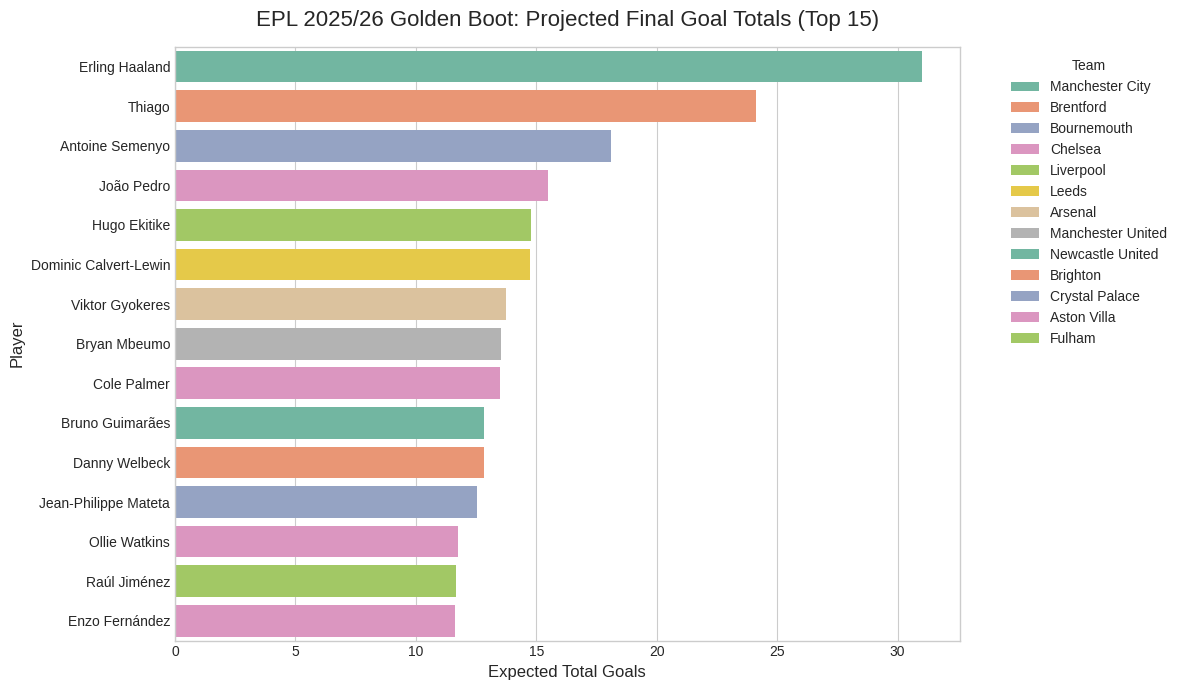

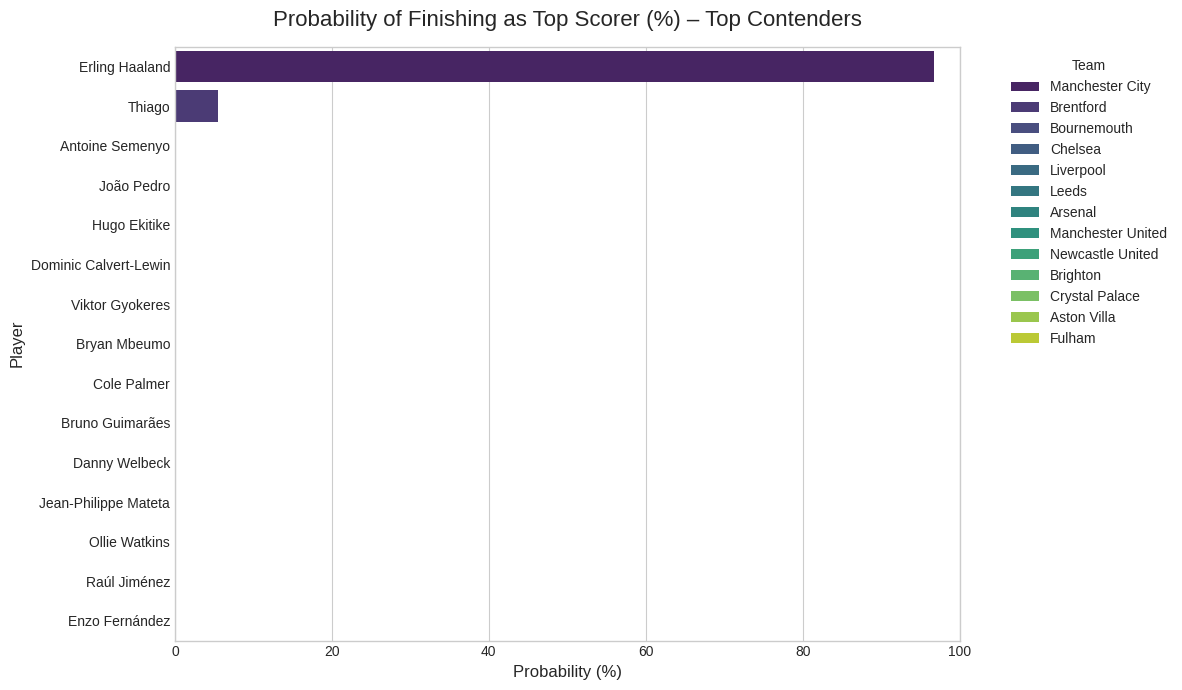

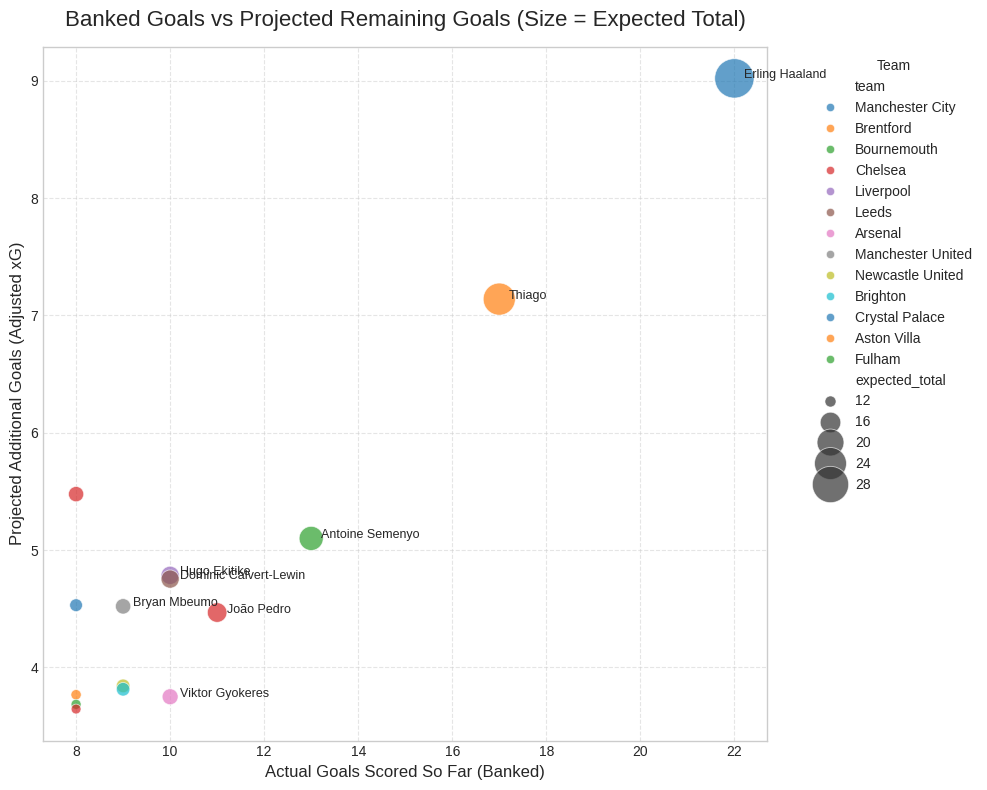

Visualizations complete! The first plot emphasizes banked goals most clearly.


In [ ]:
# =============================================================================
# Visualization: Final Golden Boot Prediction Output
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set nice style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Filter top 10-15 for plots (adjust as needed)
top_n = 15
top_contenders = contenders.sort_values('expected_total', ascending=False).head(top_n)

# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Bar chart – Expected Total Goals (emphasizes banked goals)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_contenders,
    x='expected_total',
    y='player',
    hue='team',
    dodge=False,
    palette='Set2'
)
plt.title('EPL 2025/26 Golden Boot: Projected Final Goal Totals (Top 15)', fontsize=16, pad=15)
plt.xlabel('Expected Total Goals', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Bar chart – Probability of Winning Golden Boot
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_contenders.sort_values('prob_top_scorer_%', ascending=False),
    x='prob_top_scorer_%',
    y='player',
    hue='team',
    dodge=False,
    palette='viridis'
)
plt.title('Probability of Finishing as Top Scorer (%) – Top Contenders', fontsize=16, pad=15)
plt.xlabel('Probability (%)', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.xlim(0, 100)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Plot 3: Scatter – Banked Goals vs Remaining Projection (insightful view)
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=top_contenders.astype({'goals': float, 'remaining_xG_adjusted': float, 'expected_total': float}),
    x='goals',
    y='remaining_xG_adjusted',
    size='expected_total',
    hue='team',
    sizes=(50, 800),
    alpha=0.7,
    palette='tab10'
)
plt.title('Banked Goals vs Projected Remaining Goals (Size = Expected Total)', fontsize=16, pad=15)
plt.xlabel('Actual Goals Scored So Far (Banked)', fontsize=12)
plt.ylabel('Projected Additional Goals (Adjusted xG)', fontsize=12)

# Add player labels for top few
for i, row in top_contenders.head(8).iterrows():
    plt.text(row['goals'] + 0.2, row['remaining_xG_adjusted'], row['player'], fontsize=9)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Team')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Visualizations complete! The first plot emphasizes banked goals most clearly.")